# Video Object Detection using SIFT in OpenCV

This notebook demonstrates how to use the Scale-Invariant Feature Transform (SIFT) algorithm to detect and track objects in a video. We will upload a query image (the object we want to find) and a video file, and then use SIFT to locate and track the object throughout the video.

## Import Libraries

In [ ]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import time

## Upload Query Image and Video

Please upload the query image (the object you want to find):


Saving WhatsApp Image 2025-04-19 at 21.41.54_1ae3e0d3.jpg to WhatsApp Image 2025-04-19 at 21.41.54_1ae3e0d3 (4).jpg
Please upload a video file for object detection:


Saving WhatsApp Video 2.mp4 to WhatsApp Video 2 (3).mp4


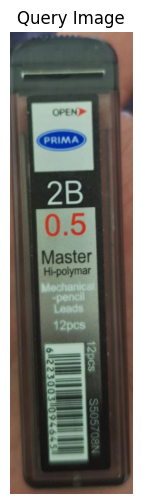

In [ ]:
# Upload query image and video
print("Please upload the query image (the object you want to find):")
query_file = files.upload()
query_filename = list(query_file.keys())[0]

print("Please upload a video file for object detection:")
video_file = files.upload()
video_filename = list(video_file.keys())[0]

## Define the Video Object Detection Function

In [ ]:
def video_object_detection(query_path, video_path, output_path="output_detected.mp4"):
    # Setup SIFT and matcher (keeping SIFT for accuracy)
    sift = cv2.SIFT_create()
    matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    # Load query image and extract features (only once)
    query_img = cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2GRAY)
    kp_query, des_query = sift.detectAndCompute(query_img, None)

    # Open video
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create output writer
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Initialize variables
    last_box = None
    last_matched_kps = None
    no_detection_count = 0
    sample_frames = []
    sample_indices = [int(total_frames * i / 5) for i in range(5)]

    # Process only every nth frame for speed
    process_every_n_frames = 1

    # Process frames
    start_time = time.time()
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        display_frame = frame.copy()

        # Only process every nth frame (for speed)
        if frame_idx % process_every_n_frames == 0:
            # Convert to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Extract features
            kp_frame, des_frame = sift.detectAndCompute(gray_frame, None)

            if des_frame is not None and len(des_frame) > 0:
                # Match features
                matches = matcher.knnMatch(des_query, des_frame, k=2)

                # Apply stricter ratio test for better matches
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.7 * n.distance:  # Stricter ratio (0.7 instead of 0.75)
                        good_matches.append(m)

                if len(good_matches) > 10:  # Require more matches for better accuracy
                    # Get coordinates
                    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                    # Find homography with stricter parameters
                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

                    if M is not None:
                        # Get corners of query image
                        h, w = query_img.shape
                        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

                        # Transform corners to frame coordinates
                        dst = cv2.perspectiveTransform(pts, M)
                        polygon = np.int32(dst)

                        # Validate the detected polygon
                        valid_detection = True

                        # Check if the polygon has a reasonable area
                        area = cv2.contourArea(polygon)
                        if area < 100 or area > (width * height * 0.5):
                            valid_detection = False

                        # Check if the aspect ratio is reasonable (not too distorted)
                        x, y, w, h = cv2.boundingRect(polygon)
                        aspect_ratio = float(w) / h if h > 0 else 0
                        original_aspect = float(query_img.shape[1]) / query_img.shape[0]
                        if aspect_ratio < 0.2 * original_aspect or aspect_ratio > 5 * original_aspect:
                            valid_detection = False

                        # Check if the polygon is convex
                        if not cv2.isContourConvex(polygon):
                            valid_detection = False

                        # Only use valid detections
                        if valid_detection:
                            # Get inlier keypoints only (using mask from homography)
                            inlier_mask = mask.ravel() == 1
                            inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inlier_mask[i]]
                            matched_kps = [kp_frame[m.trainIdx] for m in inlier_matches]

                            # Store for tracking
                            last_box = polygon
                            last_matched_kps = matched_kps
                            no_detection_count = 0

                            # Draw box
                            cv2.polylines(display_frame, [last_box], True, (0, 255, 0), 3)

                            # Draw only inlier keypoints
                            for kp in matched_kps:
                                x, y = map(int, kp.pt)
                                cv2.circle(display_frame, (x, y), 3, (0, 255, 0), -1)

                            inliers = np.sum(mask)
                            cv2.putText(display_frame, f"Matches: {inliers}", (10, 30),
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                        else:
                            no_detection_count += 1
                    else:
                        no_detection_count += 1
                else:
                    no_detection_count += 1
            else:
                no_detection_count += 1

        # Use last detected box for frames we skip processing
        elif last_box is not None and no_detection_count < 5:
            cv2.polylines(display_frame, [last_box], True, (0, 165, 255), 3)

            # Draw the last known keypoints
            if last_matched_kps:
                for kp in last_matched_kps:
                    x, y = map(int, kp.pt)
                    cv2.circle(display_frame, (x, y), 3, (0, 165, 255), -1)

            cv2.putText(display_frame, "Tracking", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 165, 255), 2)
        else:
            cv2.putText(display_frame, "No detection", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Write frame to output
        out.write(display_frame)

        # Save sample frames
        if frame_idx in sample_indices:
            sample_frames.append(display_frame.copy())

        # Print progress
        if frame_idx % 30 == 0:
            elapsed = time.time() - start_time
            fps_rate = (frame_idx + 1) / elapsed
            print(f"Processed {frame_idx+1}/{total_frames} frames ({fps_rate:.2f} fps)")

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Processing complete: {frame_idx} frames in {time.time() - start_time:.2f} seconds")
    return sample_frames

**Explanation:**
This function performs object detection on a video using the SIFT algorithm. It initializes SIFT and a FLANN-based matcher, extracts features from the query image, and processes each frame of the video to detect and track the object. The function validates detections based on area, aspect ratio, and convexity, and draws bounding boxes and keypoints on the frames. It also saves sample frames for visualization.

## Run the Object Detection and Display Sample Frames

Processed 1/195 frames (1.66 fps)
Processed 31/195 frames (4.23 fps)
Processed 61/195 frames (3.91 fps)
Processed 91/195 frames (4.26 fps)
Processed 121/195 frames (3.97 fps)
Processed 151/195 frames (3.90 fps)
Processed 181/195 frames (3.86 fps)
Processing complete: 195 frames in 51.04 seconds


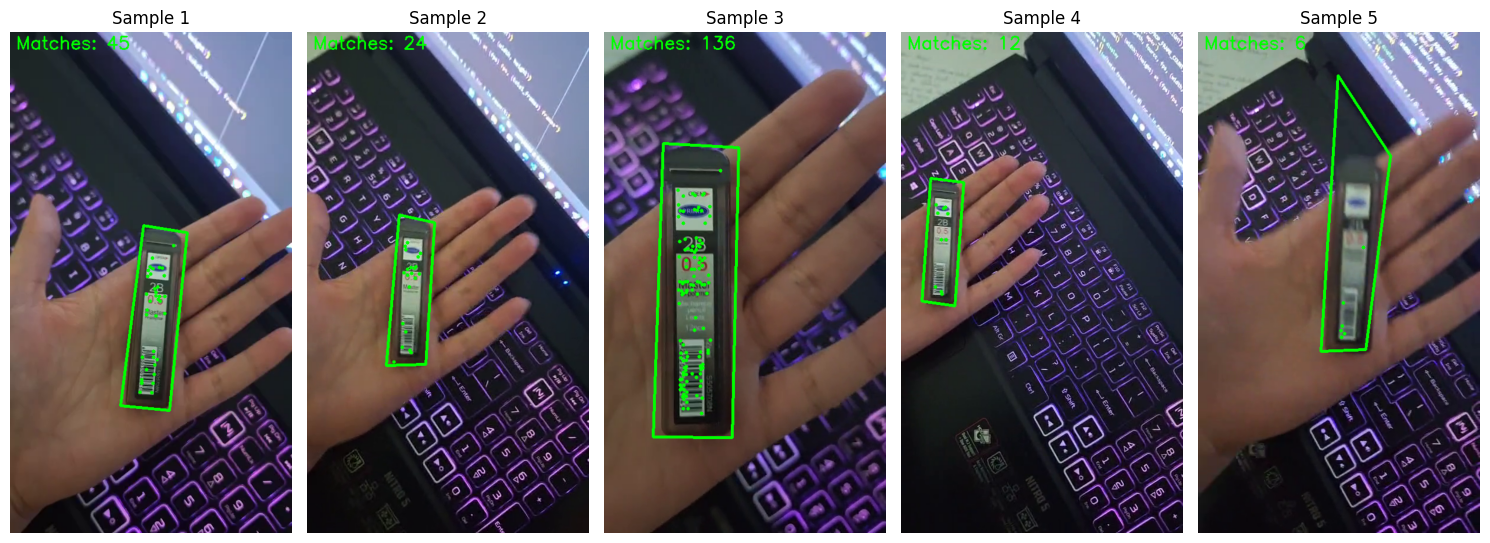

In [ ]:
# Run the object detection
sample_frames = video_object_detection(query_filename, video_filename, "output_detected.mp4")

# Display sample frames
if sample_frames:
    plt.figure(figsize=(15, 10))
    for i, frame in enumerate(sample_frames):
        plt.subplot(1, len(sample_frames), i+1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Sample {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Download the Processed Video

In [ ]:
# Download the processed video
from google.colab import files
files.download("output_detected.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>